In [1]:
import Pkg;
Pkg.add("Bloqade")
Pkg.add("PythonCall")
Pkg.add("Optim")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [2]:
using Bloqade
using PythonCall
using Optim

plt = pyimport("matplotlib.pyplot");

┌ Warning: Error requiring `KrylovKit` from `LinearSolve`
│   exception = (LoadError("/Users/kennethkohn/.julia/packages/LinearSolve/qCLK7/ext/LinearSolveKrylovKitExt.jl", 1, ArgumentError("Package LinearSolve does not have KrylovKit in its dependencies:\n- You may have a partially installed environment. Try `Pkg.instantiate()`\n  to ensure all packages in the environment are installed.\n- Or, if you have LinearSolve checked out for development and have\n  added KrylovKit as a dependency but haven't updated your primary\n  environment's manifest file, try `Pkg.resolve()`.\n- Otherwise you may need to report an issue with LinearSolve")), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000000028dcd066b, Ptr{Nothing} @0x000000028dcd0837, Ptr{Nothing} @0x000000010304c893, Ptr{Nothing} @0x00000001030824db, Ptr{Nothing} @0x00000001030812e7, Ptr{Nothing} @0x0000000103081663, Ptr{Nothing} @0x0000000103081c43, Ptr{Nothing} @0x00000001030829d7, Ptr{Nothing} @0x0000000119b44883, Ptr{Nothi

We initially used a value of $6\mu m$ for the lattice spacing, which gave us a calculated detuning parameter of $\Delta_0=-18.5$

In [71]:
C6 = 862690 #MHz um^6
(C6/6^6)

18.490440672153635

In [26]:
Δ1 = piecewise_linear(clocks=[0.0, 1, 3, 4], values=[-18.5, -18.5, 18.5, 18.5]);
Ω1 = piecewise_linear(clocks=[0.0, 1.1, 3, 4], values=π*2*[0.0, 2.0, 2.0, 0]);
Ω2 = constant(duration=2.0, value=2π*2.0);
Δ2 = constant(duration=2.0, value=0.0);

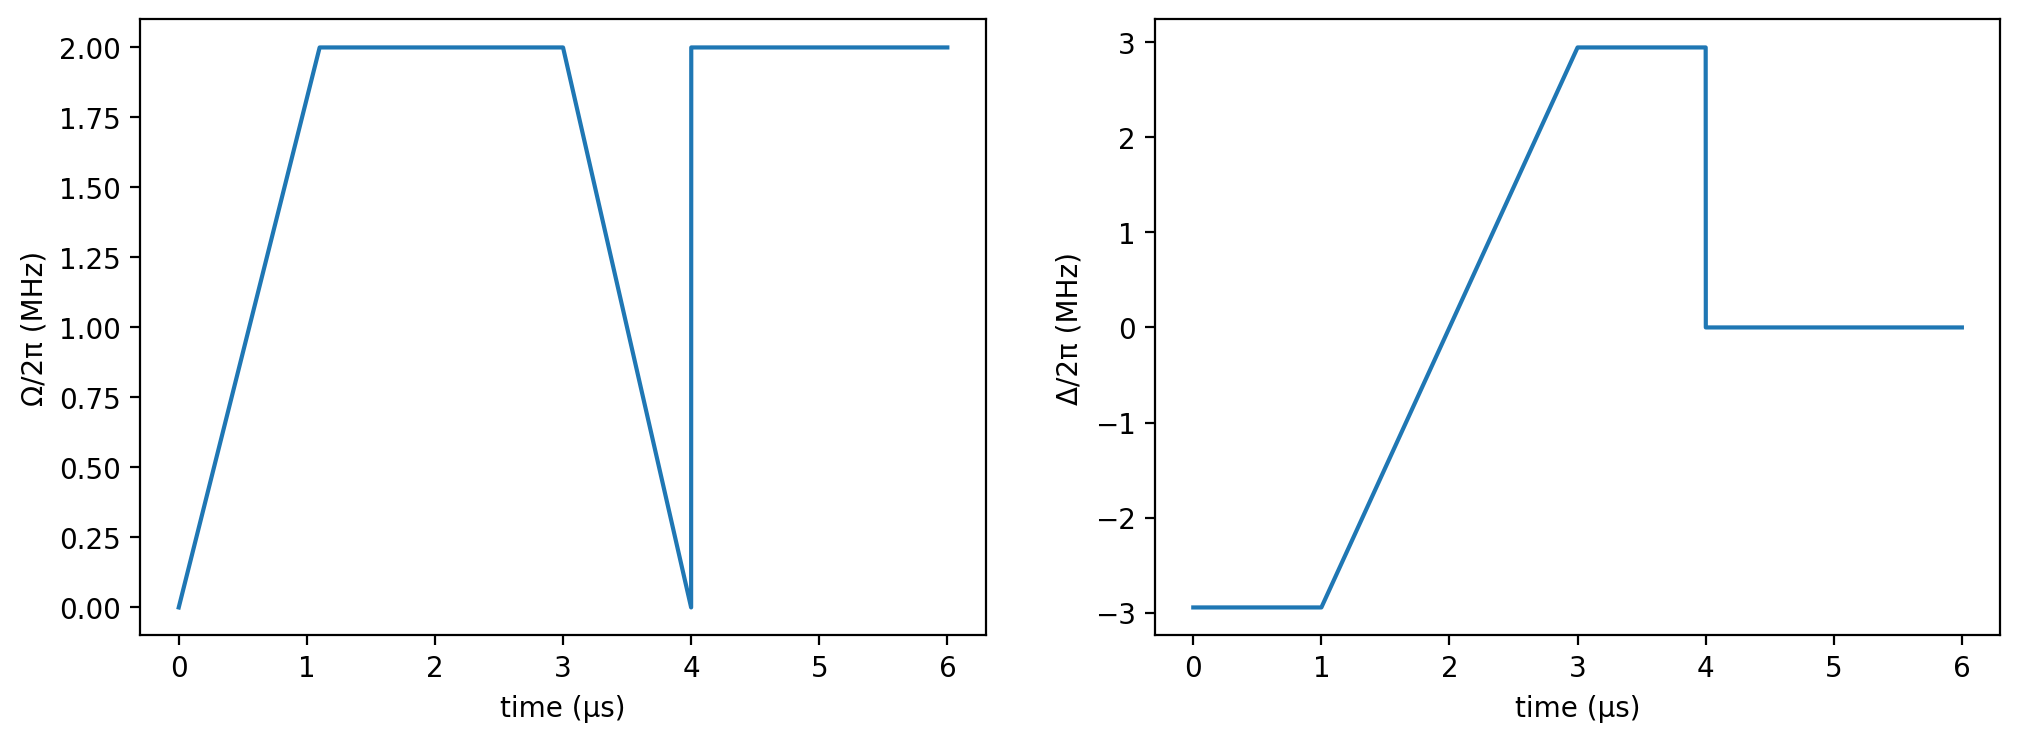

In [27]:
Ω_tot = append(Ω1, Ω2);
Δ_tot = append(Δ1, Δ2);

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω_tot)
Bloqade.plot!(ax2, Δ_tot)
ax1.set_ylabel("Ω/2π (MHz)")
ax2.set_ylabel("Δ/2π (MHz)")
fig

The following code defines the lattice structure. It is somewhat complex to ensure the points are labeled
so that bright and dark qubits alternate in the quantum scar states

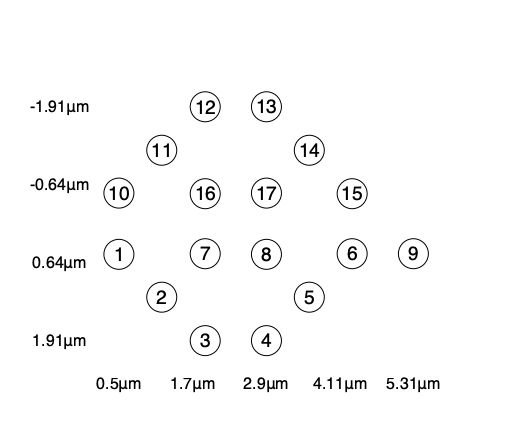

In [29]:
scaling = 1
pts_quarter = pts = [(0.5,0.5),(1.2,1.2),(0.2+1+1/sqrt(2),1.2+1/sqrt(2)),(1.2+1/sqrt(2),1.2-1/sqrt(2))]
pts_half = vcat(map(pt->(pt[1]*scaling,pt[2]*scaling), pts_quarter), map(pt-> ((1.7+1/sqrt(2)+pt[1])*scaling,pt[2]*scaling), pts_quarter))
pts_half = vcat(pts_half[1:3], (pts_half[7][1]+scaling*(-0.7-1/sqrt(2)),pts_half[7][2]),pts_half[6],pts_half[8],pts_half[4:5],(pts_half[8][1]+scaling,pts_half[8][2]))
pts_complete = vcat(pts_half, map(pt->(pt[1],-pt[2]), pts_half[1:8]))

pts_complete = map(pt->(round(pt[1], digits=2), round(pt[2],digits=2)), pts_complete)
AtomList(pts_complete)

We optimized the lattice spacing to our given detuning parameter

In [32]:
function test_spacing(s)
    s = s[1]
    points = map(pt -> (pt[1]*s,pt[2]*s), pts_complete[1:9]) #Note: only computed on the bottom half of the lattice for computational speed
    ats = AtomList(points)
    hamiltonian = rydberg_h(ats; Ω = Ω1, Δ = Δ1)
    prob = SchrodingerProblem(zero_state(9), 4, hamiltonian)
    emulate!(prob)
    return 1-abs(initval'*prob.reg)
end

initval = product_state((bit"101010101"), nbatch=NoBatch())

optresult = Optim.optimize(x -> test_spacing(x)[1],[5.0])

 * Status: success

 * Candidate solution
    Final objective value:     1.022175e-02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   2  (vs limit Inf)
    Iterations:    7
    f(x) calls:    17


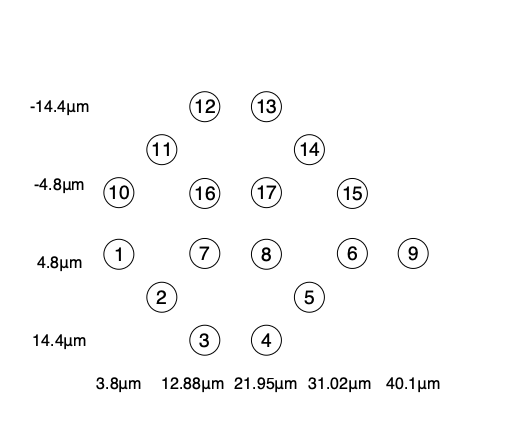

In [44]:
scale = optresult.minimizer[1]
pts_scaled = map(pt-> (round(scale*pt[1],digits=1),round(pt[2]*scale,digits=1)),pts_complete)
atoms_scaled = AtomList(pts_scaled)

From there, we simulated the full system, demonstrating no-return quantum scarring with fidelity 20%

In [56]:
reg = zero_state(17);

h = rydberg_h(atoms_scaled; Δ=Δ_tot, Ω=Ω_tot)
total_time = 6;
prob = SchrodingerProblem(reg, total_time, h);
integrator = init(prob, Vern8());

entropy = Float64[]
densities = []
returnstate_density = []
transferstate_density = []
transferstate=product_state((bit"01010101010101010"); nbatch=NoBatch())
transferstate = transferstate'
returnstate=product_state((bit"10101010101010101"); nbatch=NoBatch())
returnstate = returnstate'
for _ in TimeChoiceIterator(integrator, 0.0:1e-3:total_time)
    push!(densities, rydberg_density(reg))
    push!(transferstate_density, abs(transferstate*reg))
    push!(returnstate_density, abs(returnstate*reg))
end

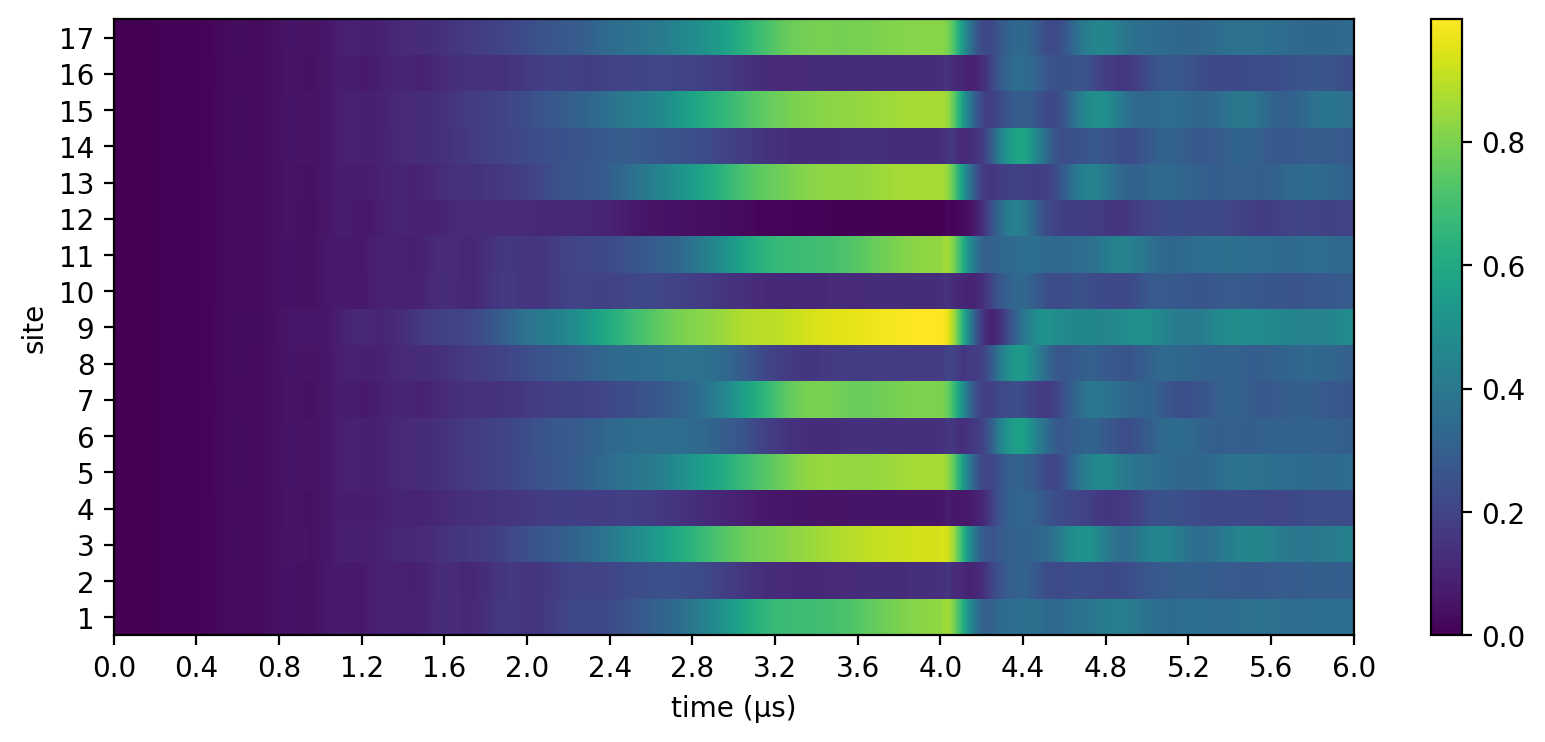

In [54]:
clocks = 0:1e-3:total_time
D = hcat(densities...)

density_matrix

fig, ax = plt.subplots(figsize = (10,4))
shw = ax.imshow(real(D), interpolation="nearest", aspect="auto", extent=[0,total_time,0.5,17+0.5])
ax.set_xlabel("time (μs)")
ax.set_ylabel("site")
ax.set_xticks(0:0.4:total_time)
ax.set_yticks(1:17)
bar = fig.colorbar(shw)
fig

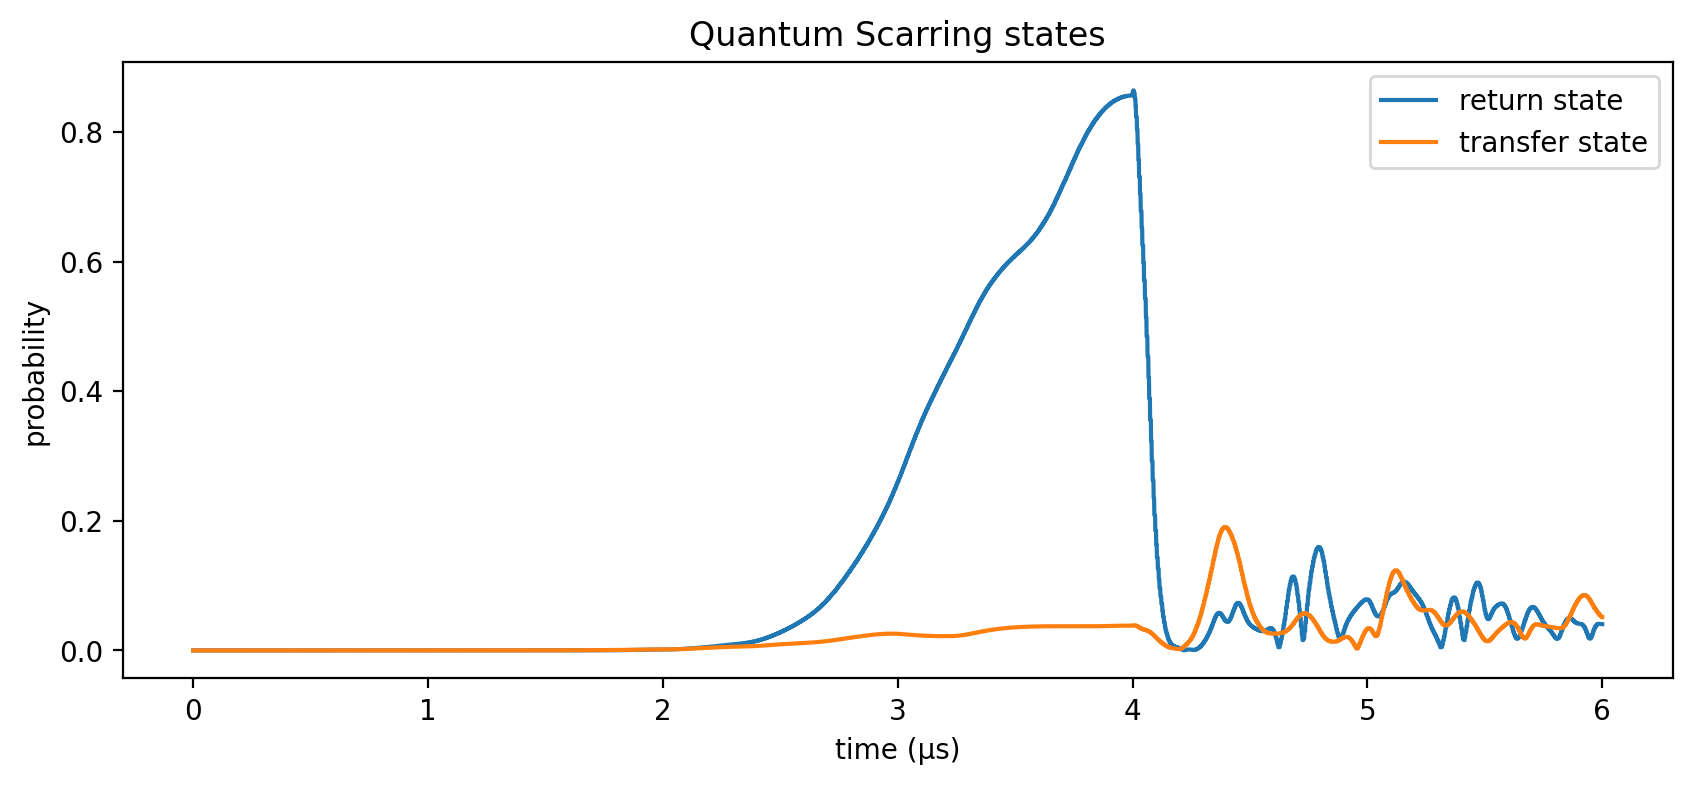

In [72]:
fig, ax = plt.subplots(figsize = (10,4))
ax.plot(LinRange(0,total_time, size(D)[2]),  returnstate_density)
ax.plot(LinRange(0,total_time, size(D)[2]),  transferstate_density)
ax.set_xlabel("time (μs)")
ax.set_ylabel("probability")
ax.legend(["return state", "transfer state"])
ax.set_title("Quantum Scarring states")
fig

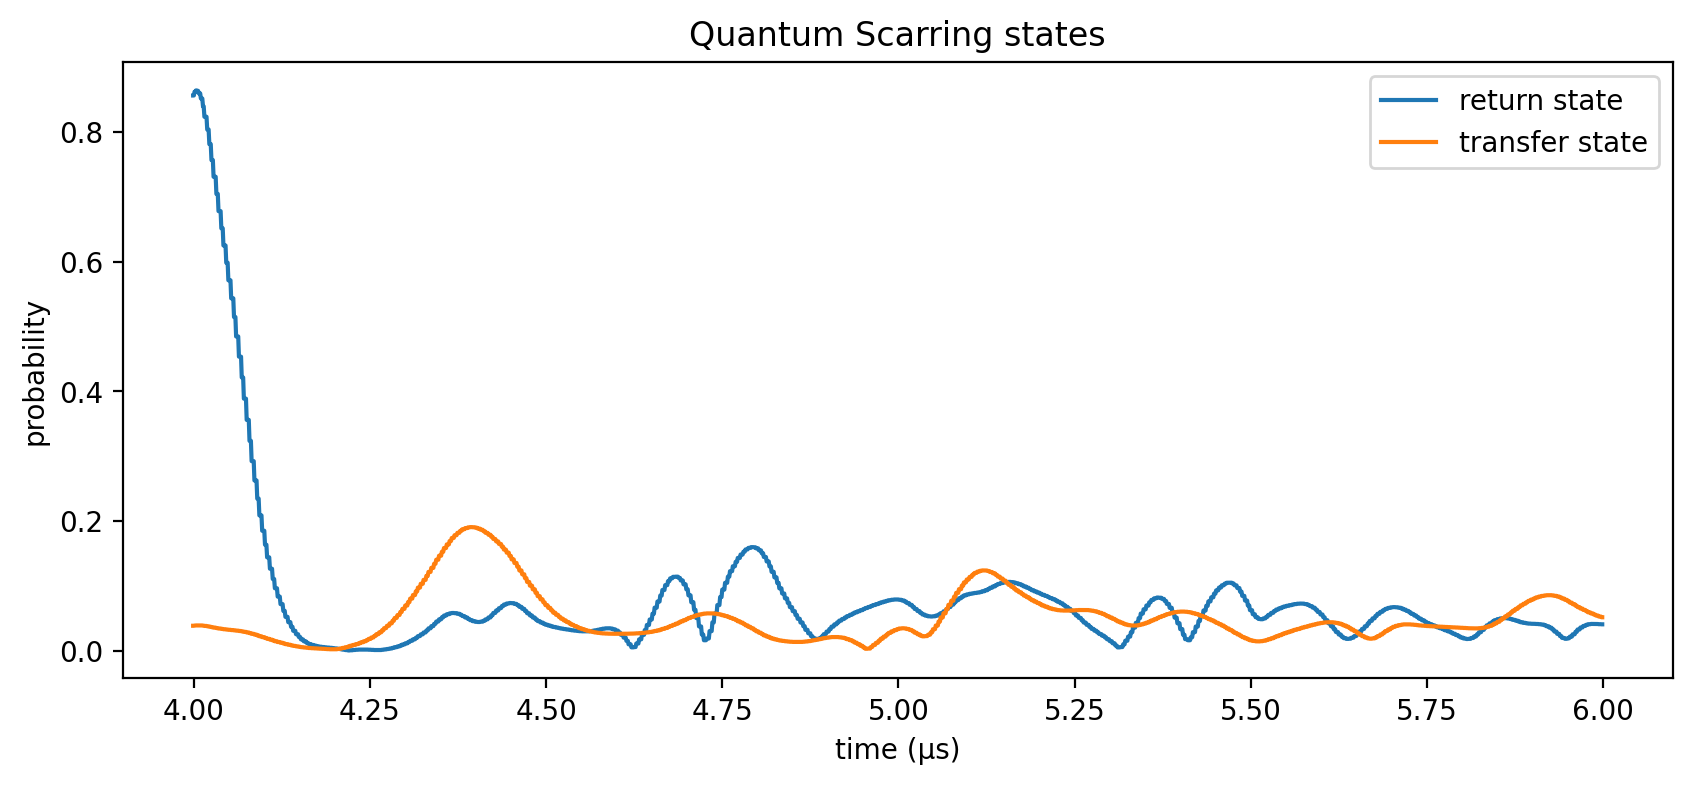

In [80]:
fig, ax = plt.subplots(figsize = (10,4))
ax.plot(LinRange(0,total_time, size(D)[2])[4000:6000],  returnstate_density[4000:6000])
ax.plot(LinRange(0,total_time, size(D)[2])[4000:6000],  transferstate_density[4000:6000])
ax.set_xlabel("time (μs)")
ax.set_ylabel("probability")
ax.legend(["return state", "transfer state"])
ax.set_title("Quantum Scarring states")
fig